## Machine Learning - Logistic Regression Example
### Kevin Jaggs Jan 2020

### Objective:

Train a Logistic Regression algorithm to an input training database. Starting with a default parameter Logistic Regression model, the aim is to tune hyperparameters, identify the most important input features and optimise classifier performance.

Outcomes at each stage will be scored using conventional binary classification scoring metrics.


### Method:

* Step 1 -  [Import the required python modules](#section_id_import_modules). Import of pandas dataframe, numpy, matplotlib and sklearn modules


* Step 2 -  [User selected parameters](#section_id_parameters). Options for user to select scoring criteria, cross validation number etc.


* Step 3 -  [Import Database_csv_to_pandas](#section_id_import_database). Import of database csv file to pandas dataframe. Note: the csv file is an independently formatted file, composed of random scoring criteria and the output column in last position [-1].


* Step 4 -  [Split dataset into test and train portions](#section_id_test_train_split). For conventional machine learning workflows, the input and output datasets are divided into training and testing sub-volumes. Algorithms are trained on the (not suprisingly) 'train' dataset and model outcomes are compared using the 'test' dataset, to prevent over-fitting.


* Step 5 -  [Feature scale input data](#section_id_feature_scale). Rescale the features/input columns such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.


* Step 6 -  [Train default Logistic Regression Classifier](#section_id_default_lrc). SKlearn Logistic Regression trained using default parameters only.


* Step 7 - [Perform GridsearchCV to fine tune hyperparameters.](#section_id_gridsearchcv)Identify the hyperparameter values to optimise model performance.


* Step 8 - [GridsearchCV model evaluation.](#section_id_gridsearchcv_evaluation) Evaluate the final GridsearchCV hyperparameter selection model using a classification report and confusion matrix.


* Step 9 - [Plot absolute variance.](#section_id_abs_variance) Plot and print the absolute variance of features output from Logistic Regression model fit.


* Step 10- [Feature section using recursive feature elimination](#section_id_rfe) Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. this routine uses the best parameter outputs of gridsearchCV and outputs a mask/filter so that the optimal features can be selected in the next section. 


* Step 11- [Filter training dataset to optimal number of features](#section_id_filter_features) Filter the input scaled training dataset based upon the the rfecv mask created in step 10.


* Step 12- [Evaluate feature selection model](#section_id_evaluate_rfe) Evaluate the feature selection model performance using a classification report and confusion matrix.


* Step 13- [ROC Plot](#section_id_roc) Comparison of the ROC curves for raw, GridsearchCV and rfe result models. Labels show the AUC score.


* Step 14- [Precision vs Recall Plot](#section_id_pr) Comparison of the PR curves for raw, GridsearchCV and rfe result models. Labels show the AUPR score.


* Step 15- [Compare model performances](#section_id_model_summary) Compare the outputs from all stages of the model evaluation: raw, GridsearchCV and RFE.


### Dataset
A synthetic dataset with a binary outcome [0,1] in the last position. Most columns are discrete values [0,1,2,3,4,5] but some are continuous floats.
Note: the supplied input file is a conditioned, synthetic binary classification dataset i.e binary outcome of 0 or 1. You can simply add in a user selected database with the following preconditions: 1) Nan or empty cell values will be replaced with zero, 2) binary outcome only, 3) the results column is the last one [-1]. 

### Programming
This evaluation is performed using Python code and SKlearn provides all the classifier modules. 

At the time of script creation the following verions were used.
Python: 3.7.6
Numpy: 1.18.1
Pandas: 1.0.1
SKlearn: 0.22.1

### Outputs
Overview plot of model fit for each classifier
Sheet of evaluation criteria ordered by descending AUC score

<a id='section_id_import_modules'></a>

### 1. Import required Python Modules

In [16]:
#print(__doc__)

#pandas dataframe - similar to a python version of excel. Most efficient way to perform data operations
import pandas as pd

#numpy for most mathematical operations
import numpy as np

#matplotlib for plotting functions
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#seaborn for plotting heatmap
#import seaborn as sns

#sklearn for machine learning modules and scoring algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#SKlearn classifier and hyperparameter search modules
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, plot_confusion_matrix,classification_report
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix,classification_report

#chi2 calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy

#recursice festure elimination
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold


#plotting
import matplotlib.pyplot as plt

from math import floor

import sys
import sklearn
print("Python version: ", sys.version_info[0],".",sys.version_info[1],".",sys.version_info[2])
print("Numpy Version: " ,np.__version__)
print("Pandas Version: " ,pd.__version__)
print("Scikitlearn Version: " ,sklearn.__version__)



Python version:  3 . 7 . 6
Numpy Version:  1.18.1
Pandas Version:  1.0.1
Scikitlearn Version:  0.22.1


<a id='section_id_parameter'></a>

### 2. User selected parameters
Select scoring method, options of 'accuracy', 'precision', 'f1', 'roc_auc'
Crossvalidation fold i.e how many subsets the training data is split into for cross validation purposes, recommend value above 3 as this below this point overfits the data and will create a prediction error in the final assessment.

In [17]:
#Accuracy - ratio of correctly predicted observation to the total observations. 
#Accuracy works best if false positives and false negatives have similar cost. 
#Accuracy = TP+TN/TP+FP+FN+TN

#Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
#High precision relates to the low false positive rate.
#Precision = TP/TP+FP

#Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
#Recall = TP/TP+FN

#F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
#Use F1 if you have an uneven class distribution. 
#If the cost of false positives and false negatives are very different - look at both Precision and Recall.
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)

#roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for different thrshold cut offs.
#The best models should plot towards the upper left quadrant of the plot, therefore calculating the area under the curve is a good measure of model performance.


#score_cat = 'roc_auc'
score_cat = 'accuracy'
#score_cat = 'precision'
#score_cat = 'f1_score'

#plot labels are updated based upon 
if score_cat == 'roc_auc':
    plot_label = 'AUC'
if score_cat == 'accuracy':
    plot_label = 'Accuracy'
if score_cat == 'precision':
    plot_label = 'Precision' 
if score_cat == 'recall':
    plot_label = 'Recall'    
if score_cat == 'f1_score':
    plot_label = 'f1 score'  
    
#number of folds (equal data subsets) employed in cross validation - recommended to use above 4 for this dataset    
cross_validation_fold = 5    

#confidnce interval for chi2 calculation
conf_int = 0.95

#see random number generators - for repeatability
random_seed = 57


<a id='section_id_import_database'></a>

### 3. Import database csv file to pandas
The csv file is imported into a pandas dataframe, allowing ease of computation in later modules. All columns are considered numeric. The column header is the data category and the index is the row ID. There should be no Nan or empty cell values amd the output column is assumed to be in last column position.

In [18]:
def readcsvfile():
    '''
    (csv)->(pandas dataframe)
    routine to read import csv file to pandas
    comma separation, column headers = first row of text
    All column data is considered numeric
    Index = row 
    -999.25 values are converted to numpy NaN
    PRECONDITION: Import csv file is the correct format. All lines without a 1/0 output removed.
    KJAGGS June 2020
    '''
    
    #read csv file to pandas dataframe
    #df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)
    df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)

    #df = df.set_index('Row ID')
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.replace(-999.25,np.NaN)
    df = df.replace(np.NaN,0)
    #print(df.isnull().any())
    return df

df = readcsvfile()

###optional qc features - remove hash/# to view 
#print(df.head)
#print(df.columns.tolist)


print("Dataframe size on import")
print("Number of prospects :", df.shape[0])
print("Number of data categories :", df.shape[1])

print("\nProportion (%) of Success:Fail outcomes")
print("1 = Success")
print("0 = Fail")
print(df.iloc[:, -1].value_counts(normalize=True) * 100)



Dataframe size on import
Number of prospects : 352
Number of data categories : 43

Proportion (%) of Success:Fail outcomes
1 = Success
0 = Fail
1    53.125
0    46.875
Name: Output Class, dtype: float64


<a id='section_id_test_train_split'></a>

### 4. Split into test and train datasets
Data is divided into test and training sub-volumes for the purpose of fitting models and preventing over-fitting/bias issues. The current defaults in the module below are to split 80:20 train:test. No random number seeding, no shuffling of input data and no stratifying (equal proportions of success/fail  outcomes in each sub-volume). These features are adjusted at the bottom of the next cell as the input to function; user can change accordingly.

In [19]:
def training_split(Xdata, Ydata, test_size=0.2,stratify=None,random_state=None,shuffle=False):
    '''
    (DataframeXColumns)(DataframeYColumn)=>(array)(array)(array)(array)
    For the purposes of splitting x and y data into test and training sets
    train_test_split is currently set to default settings
    PRECONDITION: Input datasets are formatted correctly
    KJAGGS June2020
    '''

    #split the data - default settings for now
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=test_size,stratify=stratify, random_state = random_state, shuffle = shuffle)

    #resize the output data sets if a 1 column vector, now compatible  with regression modules
    if len(X_train.shape) <2:  
       X_train = X_train.ravel()
    if len(y_train.shape) <2:  
       y_train = y_train.ravel()
    if len(X_test.shape) <2:  
       X_test = X_test.ravel()
    if len(y_train.shape) <2:  
       y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

#print(df.columns.tolist())
#output dataset is success/fail only
print(df.shape)

#remove result column from input dataset
y = df[df.columns[-1]]

#X = df.drop(df.columns[[-1]], axis=1)
#X = df.drop(df.columns[[1,-1]], axis=1)
X = df.drop(df.columns[[0,1,-1]], axis=1)



#split the datasets
#Shuffle = randomly shuffle the data before, If shuffle=False then stratify must be None.
#random state = seeding of random numbers for reproducibility across various modules
#stratify = ensure proportion of outcomes are the same across both datasets i.e % of successes in train = % of successes in test
X_train, X_test, y_train, y_test = training_split(X,y,shuffle=True,random_state=random_seed,stratify=y,test_size=0.25)

print("Train and test dataset sizes")
print("Training dataset size :", X_train.shape)
print("Test dataset size :", X_test.shape)

(352, 43)
Train and test dataset sizes
Training dataset size : (264, 40)
Test dataset size : (88, 40)


<a id='section_id_feature_scale'></a>

### 5. Feature scale the input data
Input independent variables are scaled so that the the attribute mean is zero with a unit standard deviation. Gradient descent algorithms (neural networks, for example) run more efficiently if input features are scaled accordingly.

In [20]:
#set up scaler - StandardScaler from SciKit learn
#Standardize features by removing the mean and scaling to unit variance
#z = (x - u) / s
scaler = StandardScaler()

#scaler is calculated on the train data ONLY. Would be considered data leakage - test data must not influence the model output.
scaler.fit(X_train)

#apply the scaler to the train and test datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


<a id='section_id_default_lrc'></a>

### 6. Train default parameter Logistic Regression Classifer
Using only the default parameters the SKlearn Logistic Regression is fitted to the input training dataset and performance is reviewed using a classification report and confusion matrix. Model outputs are saved for further comparison later.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

              precision    recall  f1-score   support

           0       0.66      0.61      0.63        41
           1       0.68      0.72      0.70        47

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88

Default model  AUC score:  0.7182148417228853


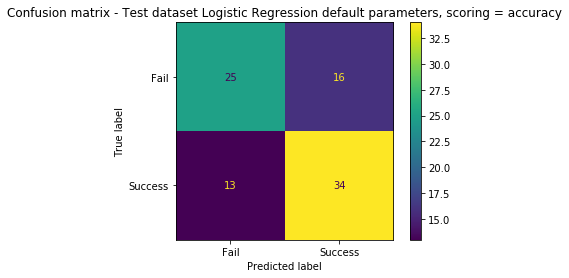

In [21]:
# Create a default logistic regression
clf_raw = linear_model.LogisticRegression(random_state=random_seed)
#Train the model using the training sets
clf_raw.fit(X_train_scaled, y_train)

#Predict the response for test dataset
#_raw suffix is used to identify this model in the final model reviews
y_pred_raw = clf_raw.predict(X_test_scaled)

#y_score_raw = clf_raw.predict_proba(X_test_scaled)
#retains positive values only
y_score_raw = clf_raw.predict_proba(X_test_scaled)[:,1]

#print("Accuracy =", accuracy_score(y_test, y_pred_raw))
#print("Precision =", precision_score(y_test, y_pred_raw))
#print('f1 = {:.2f}'.format(f1_score(y_test, y_pred_raw)))
#print("AUC =", roc_auc_score(y_test, y_pred_raw))

# print classification report 
print(classification_report(y_test, y_pred_raw)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_raw,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - Test dataset Logistic Regression default parameters, scoring = ' + score_cat)

#print(title)
#print(disp.confusion_matrix)

print("Default model  AUC score: ", roc_auc_score( y_test, y_score_raw))


<a id='section_id_gridsearchcv'></a>

### 7. Perform GridsearchCV to fine tune hyperparameters.
Identify the hyperparameter values to optimise model performance.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [22]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'C': [0.001,0.01,0.1,1,10,100,1000]
     }

 

# Create a based model
lr_cv = linear_model.LogisticRegression(random_state= random_seed)
# Instantiate the grid search model
clf_cv = GridSearchCV(estimator = lr_cv, param_grid = param_grid, 
                          cv = cross_validation_fold, n_jobs = -1, verbose = 2)

clf_cv.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=57, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

<a id='section_id_gridsearchcv_evaluation'></a>

###  8. GridsearchCV model evaluation.
Evaluate the final GridsearchCV hyperparameter selection model using a classification report and confusion matrix.

Gridsearchcv best parameters:
{'C': 0.1, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        41
           1       0.69      0.72      0.71        47

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88

GridsearchCV  AUC score:  0.7426050856253243


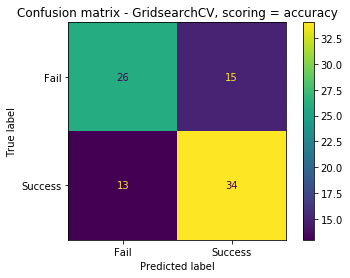

In [23]:
print("Gridsearchcv best parameters:")
print(clf_cv.best_params_)

#Predict the response for test dataset
#_rs suffix is used to identify this model as rondomised search
y_pred_cv = clf_cv.predict(X_test_scaled)

#retains positive values only
y_score_cv = clf_cv.predict_proba(X_test_scaled)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_cv)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_cv,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - GridsearchCV, scoring = ' + score_cat)

print("GridsearchCV  AUC score: ", roc_auc_score( y_test, y_score_cv))


<a id='section_id_abs_variance'></a>

###  9. Plot absolute variance.
Plot and print the absolute variance of features output from Logistic Regression model fit

                 Abs_Var
(Category 10,)  1.325622
(Category 11,)  1.022002
(Category 16,)  0.942644
(Category 13,)  0.911027
(Category 35,)  0.776936
(Category 34,)  0.775907
(Category 8,)   0.610533
(Category 27,)  0.593863
(Category 25,)  0.509161
(Category 5,)   0.505413
(Category 38,)  0.446182
(Category 41,)  0.441111
(Category 9,)   0.416815
(Category 40,)  0.416635
(Category 30,)  0.389599
(Category 12,)  0.351310
(Category 7,)   0.310912
(Category 18,)  0.302252
(Category 20,)  0.300572
(Category 39,)  0.284961
(Category 24,)  0.261343
(Category 6,)   0.258606
(Category 14,)  0.240104
(Category 22,)  0.232087
(Category 17,)  0.226243
(Category 19,)  0.223409
(Category 28,)  0.212187
(Category 21,)  0.208718
(Category 4,)   0.196057
(Category 29,)  0.183526
(Category 37,)  0.179062
(Category 3,)   0.167418
(Category 32,)  0.159381
(Category 33,)  0.157203
(Category 23,)  0.125345
(Category 26,)  0.092991
(Category 15,)  0.036944
(Category 42,)  0.009756
(Category 36,)  0.000000


Text(0.5, 1.0, 'Feature Selection - Absolute Variance, Sorted Descending')

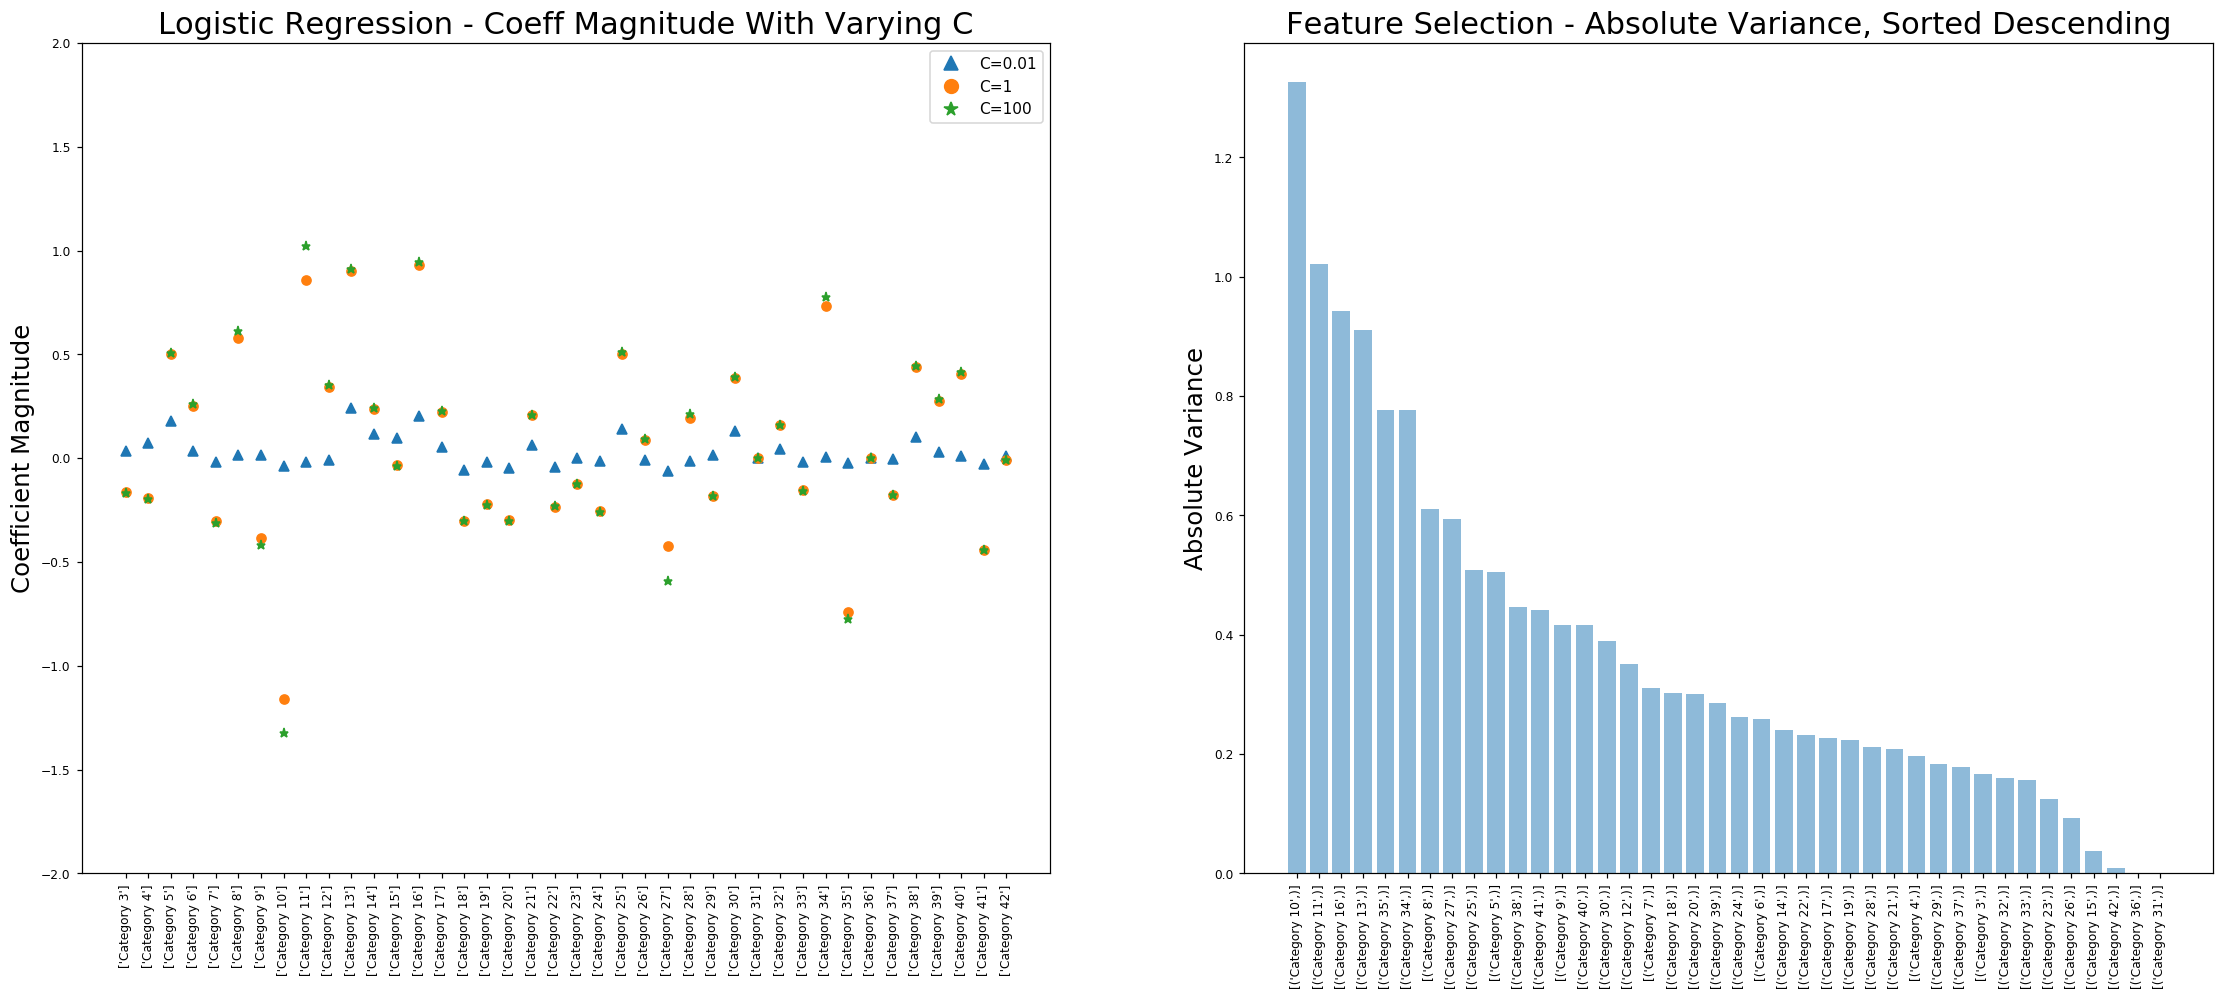

In [24]:
data = X

col_vals = data.columns.values.reshape(-1,1)

logisticRegr01 = linear_model.LogisticRegression(C=0.01)
logisticRegr01.fit(X_train_scaled, y_train) 

logisticRegr1 = linear_model.LogisticRegression(C=10)
logisticRegr1.fit(X_train_scaled, y_train) 
    
logisticRegr100 = linear_model.LogisticRegression(C=100)
logisticRegr100.fit(X_train_scaled, y_train)   

abs_var = logisticRegr100.coef_

pd_lgr = pd.DataFrame(abs(logisticRegr100.coef_).T,col_vals,columns=["Abs_Var"])
pd_lgr = pd_lgr.sort_values(by=['Abs_Var'], ascending=False)
 
sort_labels = pd_lgr.index.tolist
print(pd_lgr)
    
fig_abs_var = plt.figure(num=None, figsize=(25, 10), dpi=110, facecolor='w', edgecolor='b')
fig_abs_var.canvas.set_window_title('Logistic Regression - Feature Variance Analysis')

ax10 = fig_abs_var.add_subplot(1,2,1)
ax20 = fig_abs_var.add_subplot(1,2,2)
        
ax10.plot(logisticRegr01.coef_.T, '^', label='C=0.01')        
ax10.plot(logisticRegr1.coef_.T, 'o', label='C=1')
ax10.plot(logisticRegr100.coef_.T, '*', label='C=100')
        
#determine max y from abs max of coeff * 2
#print(floor(np.max(logisticRegr100.coef_)))
y_abs = floor(np.max(abs(logisticRegr100.coef_))) * 2

if y_abs == 0:
   y_abs = 1

labels = [item.get_text() for item in ax10.get_xticklabels()]
labels = col_vals
        
ax10.set_xticks(range(0,len(col_vals)))
ax10.set_xticklabels(labels,rotation=90)
ax10.tick_params(axis='both', which='major', labelsize=8)
ax10.set_ylabel('Coefficient Magnitude',fontsize=16)
ax10.set_title('Logistic Regression - Coeff Magnitude With Varying C',fontsize=20)
ax10.set_ylim([y_abs*-1,y_abs])
                 
ax10.legend(fontsize = 10,loc='best',markerscale = 1.5)       
    
labels = pd_lgr.index.values.reshape(-1,1)
    
y_pos = np.arange(len(col_vals))        
ax20.bar(y_pos,pd_lgr['Abs_Var'],  align='center', alpha=0.5)
a20=ax20.get_xticks().tolist()

ax20.set_xticks(range(0,len(col_vals)))
ax20.set_xticklabels(labels,rotation=90)
ax20.tick_params(axis='both', which='major', labelsize=8)

ax20.set_ylabel('Absolute Variance',fontsize=16)
ax20.set_title('Feature Selection - Absolute Variance, Sorted Descending',fontsize=20)

<a id='section_id_print_features'></a>

<a id='section_id_rfe'></a>

### 10 Feature selection using recursive feature elimination
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. this routine uses the best parameter outputs of gridsearchCV and outputs a mask/filter so that the optimal features can be selected in the next section. 
Cross validation fold is selected in module , as is the plot label.

The optimal number of features is 4
Ranking of features : 27


Text(0.5, 1.0, 'Logistic Regression - Recursive Feature Elimination')

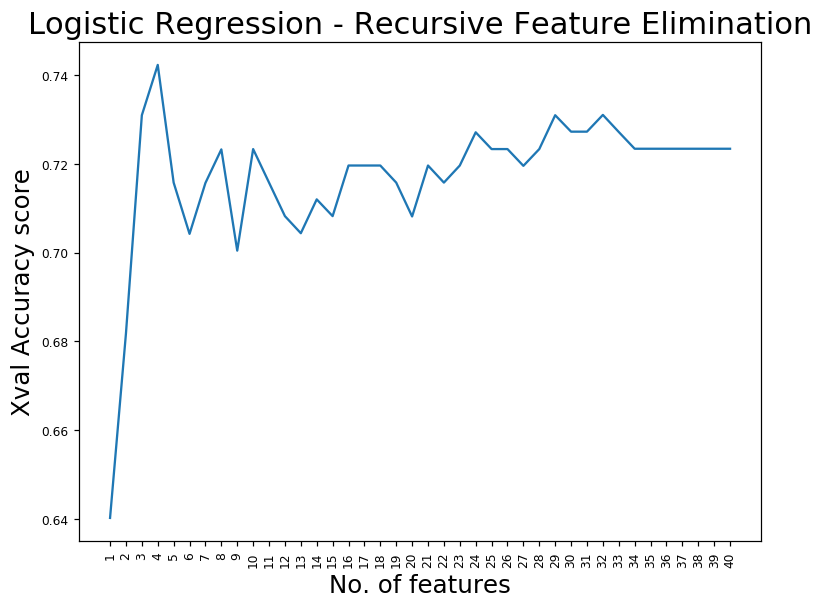

In [25]:
#Create a logistic regression Classifier based upon the best Gridsearch parameters
clf_rfe = linear_model.LogisticRegression(**clf_cv.best_params_, random_state= random_seed) # Linear Kernel

       
# The "accuracy" scoring is proportional to the number of correct
# classifications
#rfecv = RFECV(estimator=clf_rfe,min_features_to_select=9, step=1,cv = StratifiedKFold(3),scoring=score_cat)
rfecv = RFECV(estimator=clf_rfe, step=1,cv = StratifiedKFold(cross_validation_fold),scoring=score_cat)
rfecv.fit(X_train_scaled, y_train)

print('The optimal number of features is {}'.format(rfecv.n_features_))


#print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features : %d" % rfecv.ranking_[0])

#plot the results of recursive feature elimination
fig_abs_var = plt.figure(num=None, figsize=(8, 6), dpi=110, facecolor='w', edgecolor='b')
fig_abs_var.canvas.set_window_title('Support Vector Machine - Optimal Number Of Features')

ax10 = fig_abs_var.add_subplot(1,1,1)
        
ax10.plot(rfecv.grid_scores_, label='grid scores - accuracy')        

labels = [item.get_text() for item in ax10.get_xticklabels()]
labels = range(1, len(rfecv.grid_scores_) + 1)
    
ax10.set_xticks(range(0,len(col_vals)))
ax10.set_xticklabels(labels,rotation=90)
ax10.tick_params(axis='both', which='major', labelsize=8)
ax10.set_xlabel('No. of features',fontsize=16)
ax10.set_ylabel('Xval ' + plot_label + ' score',fontsize=16)
ax10.set_title('Logistic Regression - Recursive Feature Elimination',fontsize=20)

<a id='section_id_filter_features'></a>

### 11 Filter training dataset to optimal number of features
Filter the input scaled training dataset based upon the the rfecv mask created in step 10.

In [26]:
selected_features_mask = []

for item in rfecv.support_:
   selected_features_mask.append(format(item)) 

#print(mask)

selected_features = []

print("Optimal feature selection:")
for bool, feature in zip(selected_features_mask, col_vals):
    #print(bool)
    if bool == 'True':
        print(feature)
        selected_features.append(feature[0])
 


#use the boolean mask of .support_ to filter columns based upon the RFE results
#only columns which are within the selected useful features are retained
X_train_scaled_opt = X_train_scaled[:, rfecv.support_]        
X_test_scaled_opt = X_test_scaled[:, rfecv.support_]




tuned_model = linear_model.LogisticRegression(**clf_cv.best_params_)    
tuned_model.fit(X_train_scaled_opt, y_train)  

y_pred_tuned_feature = tuned_model.predict(X_test_scaled_opt)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(tuned_model.score(X_test_scaled_opt, y_test)))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tuned_feature))

Optimal feature selection:
['Category 5']
['Category 13']
['Category 16']
['Category 25']
Accuracy of logistic regression classifier on test set: 0.72
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        41
           1       0.70      0.81      0.75        47

    accuracy                           0.72        88
   macro avg       0.72      0.71      0.71        88
weighted avg       0.72      0.72      0.71        88



<a id='section_id_evaluate_rfe'></a>

### 12. Evaluate feature selection model.
Evaluate the feature selection model performance using a classification report and confusion matrix.


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67        41
           1       0.70      0.81      0.75        47

    accuracy                           0.72        88
   macro avg       0.72      0.71      0.71        88
weighted avg       0.72      0.72      0.71        88

RFE AUC score:  0.7083549558899844


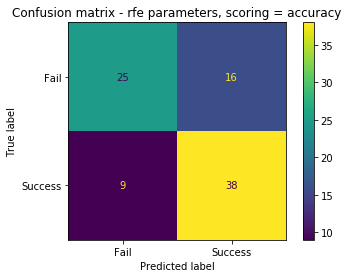

In [27]:
#Create a logistic regression Classifier
#cannot use default gridsearchcv parameters
clf_feature_selection = linear_model.LogisticRegression(**clf_cv.best_params_, random_state= random_seed) # Linear Kernel

#Train the model using the training sets
clf_feature_selection.fit(X_train_scaled_opt, y_train)

y_pred_rfe = clf_feature_selection.predict(X_test_scaled_opt) 
    
#y_score_rfe = clf_feature_selection.predict_proba(X_test_scaled_opt)
#retains positive values only
y_score_rfe = clf_feature_selection.predict_proba(X_test_scaled_opt)[:,1]

#print("Final, optimised best parameters:")
#print(clf_cv.best_params_) 

print("\nClassification Report:\n",classification_report(y_test, y_pred_rfe)) 
 
#confusion matrix plot   
disp = plot_confusion_matrix(clf_feature_selection,X_test_scaled_opt,y_test, display_labels=["Fail","Success"])

#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - rfe parameters, scoring = ' + score_cat)

print("RFE AUC score: ", roc_auc_score( y_test, y_score_rfe))

<a id='section_id_roc'></a>

### 13. ROC Plot
Comparison of the ROC curves for raw, GridsearchCV and feature selection result models. Labels show the AUC score.

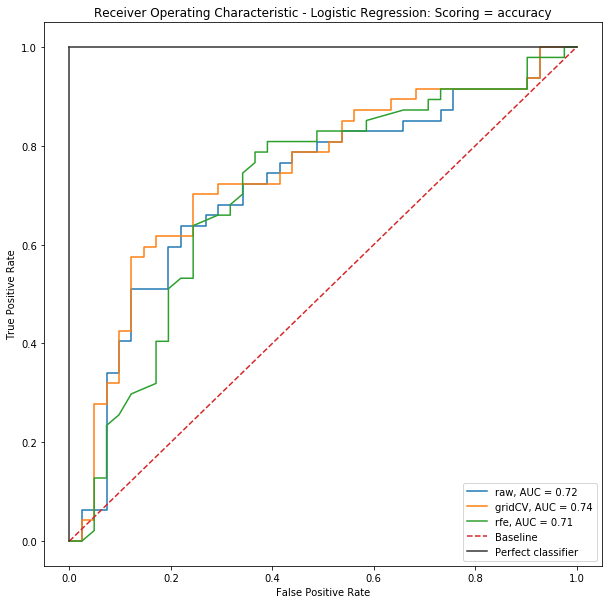

In [28]:
#ROC AUC Curve Generation for final optimised model
false_positive_raw, true_positive_raw, threshold_raw = roc_curve(y_test, y_score_raw)

#ROC AUC Curve Generation for final optimised model
false_positive_gridcv, true_positive_gridcv, threshold_tuned_feature = roc_curve(y_test, y_score_cv)

#ROC AUC Curve Generation for feature selection model
false_positive_rfe, true_positive_rfe, threshold_rfe = roc_curve(y_test, y_score_rfe)

#ROC AUC Curve Generation for final optimised model
#false_positive_chi2, true_positive_chi2, threshold_chi2 = roc_curve(y_test, y_score_chi2)

raw_auc_label = "raw, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_raw))
gridcv_auc_label = "gridCV, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_cv))
rfe_auc_label = "rfe, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_rfe))
#chi2_auc_label = "chi2, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_chi2))

#Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression: Scoring = ' + score_cat)
plt.plot(false_positive_raw, true_positive_raw, label=raw_auc_label)
plt.plot(false_positive_gridcv, true_positive_gridcv, label=gridcv_auc_label)
plt.plot(false_positive_rfe, true_positive_rfe,label=rfe_auc_label)
#plt.plot(false_positive_chi2, true_positive_chi2,label=chi2_auc_label)
plt.plot([0, 1], ls="--", label='Baseline')
plt.plot([0, 0], [1, 0] , c=".2"), plt.plot([1, 1] , c=".2",label="Perfect classifier")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

#print('roc_auc_score for Linear SVM: ', roc_auc_score(y_test, y_score_tuned_feature))

<a id='section_id_pr'></a>

### 14. Precision vs Recall Plot
Comparison of the PR curves for raw, GridsearchCV and feature selection result models. Labels show the AUPR score.


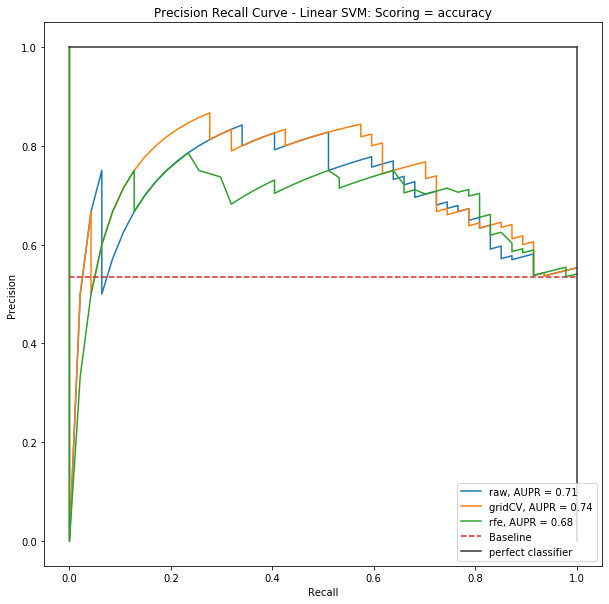

In [29]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#AUPR Curve Generation for raw model
prec_raw, recall_raw, threshold_pr_raw = precision_recall_curve(y_test, y_score_raw)

#AUPR Curve Generation for gridsearch cv model
prec_gridcv, recall_gridcv, threshold_pr_tuned_feature = precision_recall_curve(y_test, y_score_cv)

#AUPR Curve Generation for final optimised model
prec_rfe, recall_rfe, threshold_pr_rfe = precision_recall_curve(y_test, y_score_rfe)

#AUPR Curve Generation for final optimised model
#prec_chi2, recall_chi2, threshold_pr_chi2 = precision_recall_curve(y_test, y_score_chi2)

raw_pr_label = "raw, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_raw))
gridcv_pr_label = "gridCV, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_cv))
rfe_pr_label = "rfe, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_rfe))
#chi2_pr_label = "rfe, Chi2 = {:.2f}".format(average_precision_score(y_test, y_score_chi2))

baseline = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve


#Plot Precision Recall Curve
plt.subplots(1, figsize=(10,10))
plt.title('Precision Recall Curve - Linear SVM: Scoring = ' + score_cat)
plt.plot( recall_raw,prec_raw, label=raw_pr_label)
plt.plot( recall_gridcv,prec_gridcv, label=gridcv_pr_label)
plt.plot( recall_rfe,prec_rfe,label=rfe_pr_label)
#plt.plot( recall_chi2,prec_chi2,label=chi2_pr_label)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot([0, 1], [1, 1] , c=".2"), plt.plot([1, 1] , [1, 0], c=".2",label="perfect classifier")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right")
plt.show()

<a id='section_id_model_summary'></a>

### 15. Compare model performances.
Compare the outputs from all stages of the model evaluation: raw, RandomizedSearch, GridsearchCV and feature selection.

In [30]:
def summary_scores(y_test_summary, y_pred_summary, y_score_summary):
    
    print('Accuracy score on test set: {:.2f}'.format(accuracy_score(y_test_summary, y_pred_summary)))
    print('Precision score on test set: {:.2f}'.format(precision_score(y_test_summary, y_pred_summary)))
    print('Recall score on test set: {:.2f}'.format(recall_score(y_test_summary, y_pred_summary)))
    print('Micro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='micro')))
    print('Macro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='macro')))
    print('Weighted f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='weighted')))
    print("AUC  on test set: {:.2f}".format(roc_auc_score(y_test_summary, y_score_summary)))
    print("\n")

print("\nLogistic Regression Classifier: Default parameters\n")    
summary_scores(y_test, y_pred_raw, y_score_raw)

print("Logistic Regression Classifier:  GridsearchCV\n")
summary_scores(y_test, y_pred_cv, y_score_cv)

print("Logistic Regression Classifier:  Recursive Feature Elimination\n")
summary_scores(y_test, y_pred_rfe, y_score_rfe)


Logistic Regression Classifier: Default parameters

Accuracy score on test set: 0.67
Precision score on test set: 0.68
Recall score on test set: 0.72
Micro f1  score on test set: 0.67
Macro f1  score on test set: 0.67
Weighted f1  score on test set: 0.67
AUC  on test set: 0.72


Logistic Regression Classifier:  GridsearchCV

Accuracy score on test set: 0.68
Precision score on test set: 0.69
Recall score on test set: 0.72
Micro f1  score on test set: 0.68
Macro f1  score on test set: 0.68
Weighted f1  score on test set: 0.68
AUC  on test set: 0.74


Logistic Regression Classifier:  Recursive Feature Elimination

Accuracy score on test set: 0.72
Precision score on test set: 0.70
Recall score on test set: 0.81
Micro f1  score on test set: 0.72
Macro f1  score on test set: 0.71
Weighted f1  score on test set: 0.71
AUC  on test set: 0.71


